# sscan as Flyer

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for [bluesky](http://nsls-ii.github.io/bluesky) data acquisition.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

In [1]:
import asyncio
from collections import deque, OrderedDict
import numpy as np
import time

%matplotlib notebook
from bluesky.utils import install_qt_kicker
install_qt_kicker()

# common IOC prefix to be used
P = "xxx:"

In [2]:
from ophyd.scaler import ScalerCH
scaler = ScalerCH(f"{P}scaler1", name="scaler")
scaler.select_channels(None)

In [3]:
from ophyd import EpicsMotor
m1 = EpicsMotor(f"{P}m1", name="m1")

In [4]:
from apstools.synApps_ophyd import userCalcsDevice
calcs = userCalcsDevice(P, name="calcs")

In [5]:
from apstools.synApps_ophyd import sscanDevice
scans = sscanDevice(P, name="scans")
scans.select_channels()

In [6]:
from apstools.synApps_ophyd import SaveData
save_data = SaveData(f"{P}saveData_", name="save_data")

In [7]:
# configure saveData for data collection into MDA files:
        
save_data.file_system.put("/tmp")
save_data.subdirectory.put("saveData")
save_data.base_name.put("sscan1_")
save_data.next_scan_number.put(1)
save_data.comment1.put("testing")
save_data.comment2.put("configured and run from ophyd")

In [8]:
# configure the sscan record for data collection:

# clear out the weeds
scans.reset()

scan = scans.scan1
scan.number_points.put(6)
scan.positioners.p1.setpoint_pv.put(m1.user_setpoint.pvname)
scan.positioners.p1.readback_pv.put(m1.user_readback.pvname)
scan.positioners.p1.start.put(-1)
scan.positioners.p1.end.put(0)
scan.positioner_delay.put(0.0)
scan.detector_delay.put(0.1)
scan.detectors.d01.input_pv.put(scaler.channels.chan03.s.pvname)
scan.detectors.d02.input_pv.put(scaler.channels.chan02.s.pvname)
scan.triggers.t1.trigger_pv.put(scaler.count.pvname)

# finally, reconfigure
scans.select_channels()

In [9]:
# make a noisy detector in an EPICS swait record, peak ceneter at 2
from apstools.synApps_ophyd import swait_setup_lorentzian
swait_setup_lorentzian(calcs.calc2, m1, 2)
noisy_det = calcs.calc2.val

In [ ]:
def ophyd_step_scan(motor):
    """step-scan the motor and read the noisy detector"""
    t0 = time.time()
    for p in range(10):
        motor.move(p-3)
        print(
            "%8.3f" % (time.time()-t0), 
            "%8.2f" % motor.position, 
            "%8.4f" % noisy_det.get()
             )
    motor.move(0)
    print("Complete in %.3f seconds" % (time.time()-t0))

ophyd_step_scan(m1)

--------
## setup Bluesky, databroker, and the RunEngine

In [10]:
from databroker import Broker
db = Broker.named("mongodb_config")

In [11]:
from bluesky import RunEngine
import bluesky.plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import SupplementalData

RE = RunEngine({})
RE.subscribe(db.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

simple step scan using bluesky plan

Transient Scan ID: 1     Time: 2019-03-10 22:25:01
Persistent Unique Scan ID: '8048ea1b-b10a-4b9c-a56c-f174d1b7337f'
New stream: 'primary'
+-----------+------------+------------+-----------------+
|   seq_num |       time |         m1 | calcs_calc2_val |
+-----------+------------+------------+-----------------+


<IPython.core.display.Javascript object>


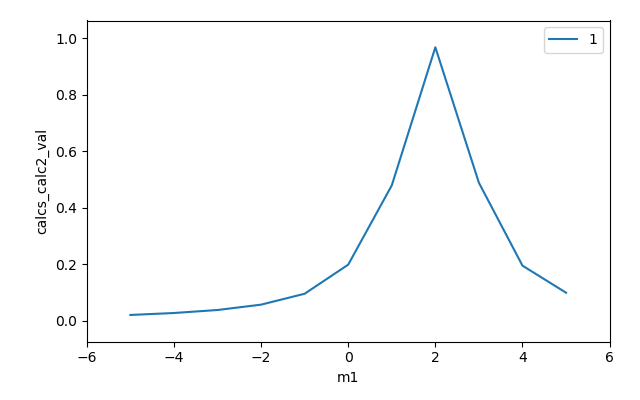

|         1 | 22:25:13.1 |   -5.00000 |         0.01993 |
|         2 | 22:25:14.4 |   -4.00000 |         0.02682 |
|         3 | 22:25:15.8 |   -3.00000 |         0.03747 |
|         4 | 22:25:17.1 |   -2.00000 |         0.05642 |
|         5 | 22:25:18.4 |   -1.00000 |         0.09509 |
|         6 | 22:25:19.7 |    0.00000 |         0.19816 |
|         7 | 22:25:21.0 |    1.00000 |         0.47891 |
|         8 | 22:25:22.3 |    2.00000 |         0.96833 |
|         9 | 22:25:23.6 |    3.00000 |         0.48813 |
|        10 | 22:25:24.9 |    4.00000 |         0.19460 |
|        11 | 22:25:26.2 |    5.00000 |         0.09875 |
+-----------+------------+------------+-----------------+
generator scan ['8048ea1b'] (scan num: 1)





('8048ea1b-b10a-4b9c-a56c-f174d1b7337f',)

In [12]:
noisy_det.kind = "hinted"
RE(bp.scan([noisy_det], m1, -5, 5, 11))

-------------------------

# Start to build our own Flyer

In [13]:
import ophyd
import bluesky
import threading
import logging

logger = logging.getLogger()

class MyFlyer(ophyd.Device):
    """
    starting template for a Flyer that we understand
    """

    def __init__(self, sscan, motor, detectors, triggers, first, last, npts, **kwargs):
        super().__init__('', parent=None, **kwargs)

        self.sscan = sscan
        self.motor = motor
        self.detectors = detectors
        self.triggers = triggers
        self.first = first
        self.last = last
        self.num_points = npts
        self.positioner_delay = 0.0
        self.detector_delay = 0.1
        self.row_data_objects = None

        self.complete_status = None
        self.t0 = 0

    def my_activity(self):
        """
        start the "fly scan" here, could wait for completion
        
        It's OK to use blocking calls here 
        since this is called in a separate thread
        from the BlueSky RunEngine.
        """
        logger.info("activity()")
        if self.complete_status is None:
            logger.info("leaving activity() - not complete")
            return
        
        # do the activity here
        scan = self.sscan
        scan.reset()

        scan.positioner_delay.put(self.positioner_delay)
        scan.positioners.p1.setpoint_pv.put(self.motor.user_setpoint.pvname)
        scan.positioners.p1.readback_pv.put(self.motor.user_readback.pvname)
        scan.positioners.p1.start.put(self.first)
        scan.positioners.p1.end.put(self.last)
        scan.number_points.put(self.num_points)

        scan.detector_delay.put(self.detector_delay)
        for i, d in enumerate(self.detectors):
            getattr(scan.detectors, "d%02d" % (i+1)).input_pv.put(d.pvname)

        for i, t in enumerate(self.triggers):
            getattr(scan.triggers, "t%d" % (i+1)).trigger_pv.put(t.pvname)
        
        # reconfigure the ophyd object for only the channels in use
        scan.select_channels()
        
        # finally, start the sscan record
        # monitor instead of wait for complete here
        # call collect when sscan indicates new data is ready
        scan.execute_scan.put(1)

        row_contents = []
        for part in (scan.positioners, scan.detectors):
            for chname in part.read_attrs:
                if not chname.endswith("_value"):
                    continue
                row_contents.append(getattr(part, chname))
        self.row_data_objects = row_contents
        
        last_point = scan.current_point.get()
        
        # once started, we notify by updating the status object
        self.kickoff_status._finished(success=True)

        # TODO: wait for completion
        while True:
            current_point = scan.current_point.get()
            if last_point != current_point and current_point > 0:
                pass    # this is the time to call collect()
            last_point = current_point
            if scan.scan_phase.get() in (0, "IDLE"):
                break
            time.sleep(0.001) 
    
        # after the wait, we declare victory
        self.complete_status._finished(success=True)
        logger.info(f"activity() complete. status = {self.complete_status}")

    def kickoff(self):
        """
        Start this Flyer
        """
        logger.info("kickoff()")
        self.kickoff_status = ophyd.DeviceStatus(self)
        self.complete_status = ophyd.DeviceStatus(self)
        
        thread = threading.Thread(target=self.my_activity, daemon=True)

        self.t0 = time.time()
        thread.start()
        return self.kickoff_status

    def complete(self):
        """
        Wait for flying to be complete
        """
        logger.info("complete()")
        if self.complete_status is None:
            raise RuntimeError("No collection in progress")

        return self.complete_status

    def describe_collect(self):
        """
        Describe details for ``collect()`` method
        """
        logger.info("describe_collect()")

        stream = OrderedDict()
        for item in self.row_data_objects:
            key = item.name.lstrip(scan.name+"_")
            stream[key] = dict(
                source = item.name,
                dtype = "number",
                shape = (1,)
            )
        return {"primary" : stream}

    def collect(self):
        """
        Start this Flyer
        """
        logger.info("collect()")
        self.complete_status = None
        t = time.time()

        dstream = OrderedDict()
        tstream = OrderedDict()
        for item in self.row_data_objects:
            key = item.name.lstrip(scan.name+"_")
            dstream[key] = item.get()
            tstream[key] = t

        yield dict(
            time=t,
            data=dstream,
            timestamps=tstream
        )

In [14]:
ifly = MyFlyer(
    scans.scan1, 
    m1, 
    [scaler.channels.chan03.s, scaler.channels.chan02.s, calcs.calc1.val], 
    [scaler.count, calcs.calc1.process], 
    -3, 
    6, 
    11, 
    name="ifly")

In [15]:
ifly.kickoff()

DeviceStatus(device=ifly, done=False, success=False)

In [16]:
ifly.complete()

DeviceStatus(device=ifly, done=False, success=False)

In [17]:
ifly.describe_collect()

{'primary': OrderedDict([('positioners_p1_readback_value',
               {'source': 'scans_scan1_positioners_p1_readback_value',
                'dtype': 'number',
                'shape': (1,)}),
              ('positioners_p1_setpoint_value',
               {'source': 'scans_scan1_positioners_p1_setpoint_value',
                'dtype': 'number',
                'shape': (1,)}),
              ('detectors_d01_current_value',
               {'source': 'scans_scan1_detectors_d01_current_value',
                'dtype': 'number',
                'shape': (1,)}),
              ('detectors_d02_current_value',
               {'source': 'scans_scan1_detectors_d02_current_value',
                'dtype': 'number',
                'shape': (1,)}),
              ('detectors_d03_current_value',
               {'source': 'scans_scan1_detectors_d03_current_value',
                'dtype': 'number',
                'shape': (1,)})])}

In [21]:
ifly.collect()

<generator object MyFlyer.collect at 0x00000201504B5DE0>

In [22]:
g = _
print(list(g))

[{'time': 1552274846.914526, 'data': OrderedDict([('positioners_p1_readback_value', 6.0), ('positioners_p1_setpoint_value', 6.000000000000001), ('detectors_d01_current_value', 2.0), ('detectors_d02_current_value', 3.0), ('detectors_d03_current_value', 0.0)]), 'timestamps': OrderedDict([('positioners_p1_readback_value', 1552274846.914526), ('positioners_p1_setpoint_value', 1552274846.914526), ('detectors_d01_current_value', 1552274846.914526), ('detectors_d02_current_value', 1552274846.914526), ('detectors_d03_current_value', 1552274846.914526)])}]


In [23]:
RE(bp.fly([ifly]))

Transient Scan ID: 3     Time: 2019-03-10 22:27:57
Persistent Unique Scan ID: '5f2bc621-4972-427b-bd73-2ae877ae1f2b'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
+-----------+------------+
generator fly ['5f2bc621'] (scan num: 3)





('5f2bc621-4972-427b-bd73-2ae877ae1f2b',)

In [24]:
h = db[-1]
print(h.stream_names)

['primary']


In [25]:
h.table("primary")

,time,positioners_p1_readback_value,positioners_p1_setpoint_value,detectors_d01_current_value,detectors_d02_current_value,detectors_d03_current_value
seq_num,,,,,,
1,2019-03-10 22:28:26.062897444,6.0,6.0,2.0,2.0,0.0


In [26]:
list(h.documents())

[('start',
  {'time': 1552274877.8031926,
   'uid': '5f2bc621-4972-427b-bd73-2ae877ae1f2b',
   'scan_id': 3,
   'plan_type': 'generator',
   'plan_name': 'fly'}),
 ('descriptor',
  {'run_start': '5f2bc621-4972-427b-bd73-2ae877ae1f2b',
   'data_keys': {'positioners_p1_readback_value': {'source': 'scans_scan1_positioners_p1_readback_value',
     'dtype': 'number',
     'shape': [1]},
    'positioners_p1_setpoint_value': {'source': 'scans_scan1_positioners_p1_setpoint_value',
     'dtype': 'number',
     'shape': [1]},
    'detectors_d01_current_value': {'source': 'scans_scan1_detectors_d01_current_value',
     'dtype': 'number',
     'shape': [1]},
    'detectors_d02_current_value': {'source': 'scans_scan1_detectors_d02_current_value',
     'dtype': 'number',
     'shape': [1]},
    'detectors_d03_current_value': {'source': 'scans_scan1_detectors_d03_current_value',
     'dtype': 'number',
     'shape': [1]}},
   'time': 1552274906.0359716,
   'uid': '875588c5-2828-4423-ac45-27593b2a3b82